In [ ]:
#!pip install clustergram pandas_profiling scipy sklearn statsmodels IPython dtale matplotlib rpy2 seaborn shap

In [ ]:
#put in ~/.bashrc
#LD_PRELOAD="/mnt/distvol/R/4.1.2/lib64/R/lib/LibR.so"

In [185]:
#from fracdiff import fdiff
#import urbangrammar-graphics as ugg
%matplotlib inline
import os
from clustergram import Clustergram
from concurrent.futures import ALL_COMPLETED
from concurrent.futures import wait
from dask.distributed import as_completed
from dask.distributed import Client
from dask.distributed import Semaphore
from dateutil.relativedelta import relativedelta
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from numpy import absolute
from numpy import arange
from numpy import mean
from numpy import std
from pandas import read_csv
from pandas_profiling import ProfileReport
#from rpy2.robjects import pandas2ri
from pmdarima.arima import auto_arima
from pmdarima.utils import diff_inv
from rpy2.robjects.conversion import localconverter
from rpy2.robjects.packages import importr
from rpy2.rinterface_lib import openrlib
from scipy import stats
from scipy.cluster.vq import vq
from scipy.spatial.distance import cdist, pdist
from scipy.special import boxcox, inv_boxcox
from scipy.stats import f
from scipy.stats import skew
from scipy.stats import kurtosis
import scipy.stats as stats
from sklearn import preprocessing
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import *
#from sklearn.preprocessing import PowerTransformer
#from sklearn.preprocessing import StandardScaler
#from sklearn.preprocessing import scale
from sklearn.utils import as_float_array
from statsmodels.formula.api import ols
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.outliers_influence import OLSInfluence
import statsmodels.api as sm
import IPython
import concurrent.futures
import dask.dataframe as dd
import datetime
import dtale
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pingouin as pg
import pmdarima
import pycorrelate
import random
import re
import rpy2
import rpy2.robjects as ro
import rpy2.situation
import scipy
import seaborn as sn
import shap
import sklearn
import sklearn.linear_model
import statsmodels.api as sm
import statsmodels.tools
import sys
import time
if not sys.warnoptions:
	import warnings
	warnings.simplefilter("ignore")


In [ ]:
#c = get_config()
libpath = os.environ.get('LD_LIBRARY_PATH', '')
os.environ['LD_LIBRARY_PATH'] = (
    rpy2.situation.r_ld_library_path_from_subprocess(openrlib.R_HOME) +
    libpath
)

In [ ]:
def testNormal (x):    
    
    k2, p = stats.normaltest(x)
    alpha = .001  
    if p < alpha: 
        # null hypothesis: x comes from a normal distribution
        return 1
    else:
        return 0
    
def returnYeo (x,training=False):
    if(bool(training)):
        xt, _ = stats.yeojohnson(x.loc[training])
        xt = pd.DataFrame(xt)
    else:
        xt, _ = stats.yeojohnson(x)
        xt = pd.DataFrame(xt)        
    return([xt,_])

def regress(dd_df,numCV=2):
    
    lr = LinearRegression()
    print("y needs to be named 'target', regress only uses the variable names, it doesn't use index's.  You apply that using .fit on this functions return")
    #dd_df = data_final
    variables=dd_df.columns
    target = variables[0]
    te = pd.DataFrame(dd_df['target']) 
    te.index = ([*dd_df.index])
    #te.columns = ['target']
    col_names = variables[~variables.isin(['target'])].ravel()

    s_f_s = sfs(lr, 
              k_features=np.int(len(col_names)*.05), 
              forward=True, 
              floating=True, 
              scoring='neg_mean_absolute_percentage_error',
              n_jobs=1,
              cv=numCV)

    return (s_f_s)

def last_day_of_month(date):
    return date.replace(day=1) + relativedelta(months=1) - relativedelta(days=1)

def findknee(xdata):
    rate_of_change=(xdata[0]-xdata[-1])/(len(xdata)-1)
    #print(rate_of_change)
    delta = xdata-xdata[-1]
    deltas = []
    deltas.append(delta[0])
    for d in range(1,len(xdata)):
        deltas.append(deltas[d-1]-rate_of_change)
    #print(deltas)
    for d in range(0,len(xdata)):
        deltas[d]=delta[d]-deltas[d]
    return(np.abs(deltas))
    
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

def formula_from_cols(df, y):
    return y + ' ~ ' + ' + '.join([col for col in df.columns if not col==y])

def inverse_boxcox (data, lambdas):
    power = PowerTransformer(method='yeo-johnson')
    power.lambdas_ = lambdas.values
    return(power.inverse_transform([data]))
    #return inv_boxcox(data, lambdas.values)
    
#yeho
def transform_boxcox_l(data, l_):
    transformed = pd.DataFrame()

    for i in range(0,len(data.columns)):
        #print(i)
        if l_.iloc[i].values == 1:
            inner_scale = data.iloc[:,i]            
        else:
            inner_scale = pd.DataFrame(stats.yeojohnson((data.iloc[:,i]), lmbda=l_.iloc[i].values))
            
        inner_scale.index = data.index
        transformed = pd.concat([transformed,inner_scale],axis=1)
        
    transformed.columns = data.columns
    return transformed

def transform_boxcox (data):
    transformed = pd.DataFrame()
    transformed_lambdas = pd.DataFrame()

    if (len(data.columns)==1):
        inner_scale, l = returnYeo(data)
        inner_scale.set_index(data.index)

        transformed_lambdas = pd.concat([transformed_lambdas,pd.DataFrame(pd.Series(l))],axis=0)
        transformed = pd.concat([transformed,inner_scale],axis=1)        
    else:
        for i in range(0,len(data.columns)):
            inner_scale, l = returnYeo(data.iloc[:,i])
            inner_scale.set_index(data.index)

            transformed_lambdas = pd.concat([transformed_lambdas,pd.DataFrame(pd.Series(l))],axis=0)
            transformed = pd.concat([transformed,inner_scale],axis=1)

    transformed.columns = data.columns
    return transformed, transformed_lambdas

def inverse_yeo(og, data_, lambda_):
    values = []
    for i in range(0,len(og)):
        X = og[i]
        X_trans = data_[i]
        if X >= 0 and lambda_ == 0:
            X = exp(X_trans) - 1
        elif X >= 0 and lambda_ != 0:
            X = (X_trans * lambda_ + 1) ** (1 / lambda_) - 1
        elif X < 0 and lambda_ != 2:
            X = 1 - (-(2 - lambda_) * X_trans + 1) ** (1 / (2 - lambda_))
        elif X < 0 and lambda_ == 2:
            X = 1 - exp(-X_trans)
        
        values.append(X)
    return(pd.DataFrame(values))

def revert_yeo (og, data_, lambdas):
    reverted = pd.DataFrame()

    for i in range(0,len(data_.columns)):        
        if lambdas.iloc[i].values == 1 :
            revert = data_.iloc[:,i]
        else:
            p#ower = PowerTransformer(method='yeo-johnson')
            #power.lambdas_ = lambdas.iloc[i].values
            #revert = pd.DataFrame(power.inverse_transform([data.iloc[:,i].values]))
            #return inv_boxcox(data, lambdas.values)
            revert = pd.DataFrame(inverse_yeo(og.iloc[:,i].values,data_.iloc[:,i].values, lambdas.iloc[i].values))            
        revert.index = data_.index
        reverted = pd.concat([reverted,revert],axis=1)
        
    reverted.columns = data_.columns
    return reverted

class ZCA(BaseEstimator, TransformerMixin):
  def __init__(self, regularization=1e-5, copy=False):
      self.regularization = regularization
      self.copy = copy
  def fit(self, X, y=None):
      X = as_float_array(X, copy=self.copy)
      self.mean_ = np.mean(X, axis=0)
      X = X - self.mean_
      sigma = np.dot(X.T, X) / (X.shape[0] - 1)
      U, S, V = np.linalg.svd(sigma)
      tmp = np.dot(U, np.diag(1 / np.sqrt(S + self.regularization)))
      self.components_ = np.dot(tmp, U.T)
      return self
  def transform(self, X):
      X_transformed = X - self.mean_
      X_transformed = np.dot(X_transformed, self.components_.T)
      return X_transformed

def crosscorrelation(x, y, maxlag, mode='corr'):
    """
    Cross correlation with a maximum number of lags.

    `x` and `y` must be one-dimensional numpy arrays with the same length.

    This computes the same result as
        numpy.correlate(x, y, mode='full')[len(a)-maxlag-1:len(a)+maxlag]

    The return vaue has length 2*maxlag + 1.
    """
    py = np.pad(y.conj(), 2*maxlag, mode='constant')
    T = np.lib.stride_tricks.as_strided(py[2*maxlag:], shape=(2*maxlag+1, len(y) + 2*maxlag),
                   strides=(-py.strides[0], py.strides[0]))
    px = np.pad(x, maxlag, mode='constant')
    if mode == 'dot':       # get lagged dot product
        return T.dot(px)
    elif mode == 'corr':    # gets Pearson correlation
        return (T.dot(px)/px.size - (T.mean(axis=1)*px.mean())) / \
               (np.std(T, axis=1) * np.std(px)) 
    
def train(partition):
    est = LinearRegression()
    est.fit(partition[New_Names].values, partition['target'])
    return est

    '''
    
def nv_diff_sets(v_of_i,dataset,f_casts):

  s_=sndif_[which(colnames(raw)==var_of_int)]
  d_=ndif_[which(colnames(raw)==var_of_int)]
  
  startRow = c()
  for (r in rownames(dataset[1:d_,,drop=FALSE])):
    startRow = c(startRow,which(rownames(raw)==r))
  
  data_ = c(na.omit(c(dataset[,var_of_int], f_casts)))
  
  if(s_==0):
    inv_d = diffinv(data_,differences=d_,xi=raw[startRow,var_of_int])
  else:  
    inv_d = diffinv(diffinv(data_,differences = d_, xi=raw[startRow,var_of_int]), differences = s_,xi=raw[startRow:(startRow+season-1),var_of_int])
    
  return(inv_d)
'''
#define F-test function
def f_test(x, y):
    x = np.array(x)
    y = np.array(y)
    f = np.var(x, ddof=1)/np.var(y, ddof=1) #calculate F test statistic 
    dfn = x.size-1 #define degrees of freedom numerator 
    dfd = y.size-1 #define degrees of freedom denominator 
    p = 1-scipy.stats.f.cdf(f, dfn, dfd) #find p-value of F test statistic 
    return f, p

def lagpad(x, k):
    length=np.full(abs(k), np.NaN)
    #print(length)
    #k=k-1
    if (k>0):
        result = np.concatenate([length,x[0:(len(x)-k)]])
    elif (k<0):
        result= np.concatenate([(x[abs(k):(len(x))]),length])
    else:
        result= x
    return(result)

def lag(data):
    return lagpad(data,1)

def sndif_(npa_):
    name = npa_[0]
    index = npa_[2]
    #print(index)
    data = raw_int[name].loc[index]
    #print(data)
    return([name,pmdarima.arima.nsdiffs(data.dropna(),m=npa_[1])])

def ndif_(npa_):
    name = npa_[0]
    index = npa_[1]
    data = deseasoned[name].loc[index]

    score = pmdarima.arima.ndiffs(data.dropna())
    
    if(score==0):
        score = 1
    return([name,score])

def collect():
    import gc
    gc.collect()

def clientFunction(function_name,vars_):
    client = Client('192.168.3.100:8786',timeout=3)
    future_ = client.map(function_name,vars_)
    
    results = []
    #my intent was to capture future objects vs results and this gave me results
    for f_ in as_completed(future_):
        if(f_.status=="error"):
            results.append("error")
        else:
            results.append(f_.result()) 

    client.close()

    return results

def returnElement(v):
    return(v[0])

def returnResults(v):
    return(v[1])

def restartClientFunction():
    client = Client('192.168.3.100:8786',timeout=3)
    client.restart()
    client.close()

def ts_cv_split (dataset):
    #rmse = []

    both_ = []
    #train_ = []
    #test_ = []
    for train_index, test_index in tscv.split(outer_dataset.index):
        #train_.append(train_index)
        #test_.append(test_index)
        both_.append([train_index,test_index])    
    return(both_)

def return_ts_cv_data (indexes):
    dataset=outer_dataset
    #print(indexes[0])
    return([dataset.iloc[indexes[0]],dataset.iloc[indexes[1]]])

def cv_pcor_check (npa_):
    
    #data = npa_
    n = npa_[2]
    New_Names_testing = list(np.array(New_Names)[(np.array(New_Names)!=n)])
    #print(npa_[0])
    
    #dataset= outer_dataset
    #train_index = npa_[0]
    #print(train_index)
    #test_index = npa_[1]
    
    #I don't need it to do training/test splits, but I had advanced ideas that would apply linear models to a test partition and go with the best error reduction... 
    # but partial correlations are just that except they don't take into consideration training/test partitions

    #target.iloc[training].iloc[train_index]
    subset_train = npa_[0]#dataset.iloc[train_index]
    train_index = subset_train.index
    subset_train = subset_train.dropna()
    subset_test = npa_[1]#dataset.iloc[test_index]
    #return(subset_test)
    test_index = subset_test.index
    subset_test = subset_test.dropna()
    
    y_reg_train_no_x = LinearRegression().fit(subset_train[New_Names_testing], subset_train['target'])
    y_fore_no_x = y_reg_train_no_x.predict(subset_test[New_Names_testing])
    y_resid_no_x = y_fore_no_x.ravel()-subset_test['target']
    
    x_reg_train_no_x = LinearRegression().fit(subset_train[New_Names_testing], subset_train[n])
    x_fore_no_x = x_reg_train_no_x.predict(subset_test[New_Names_testing])
    x_resid_no_x = x_fore_no_x.ravel()-subset_test[n]
    
    cor_resid = pd.concat([pd.DataFrame(y_resid_no_x),pd.DataFrame(x_resid_no_x)],axis=1).corr()
    #model_name = ols(formula_from_cols(subset, 'target'),data=data_final_dask_w_y[subset.columns].compute().iloc[train_index]).fit()
    #print(model_name.summary())

    #skip y and states
    #set_ = subset.loc[:, ~subset.columns.isin([target])].columns.tolist()
    
    c_value = np.array(cor_resid).ravel()[1]
    
    return(c_value)

#correlation p values
def pvalues(n):
    #n = New_Names[0]
    New_Names_testing = list(np.array(New_Names)[(np.array(New_Names)!=n)])

    p_values = pd.DataFrame()
    #inner_c_values = []

    #outer_dataset is derived from trainings
    indexes = ts_cv_split(outer_dataset)
    
    data = clientFunction(return_ts_cv_data,indexes)
    #print(data)
    #print(data)
    new_data = []
    
    for d in data:
        #print(d[0])
        #print(d[1])
        #print(n)
        new_data.append([d[0],d[1],n])
    #inner_c_values = []
    #print(new_data[0][0])
    #print(cv_pcor_check(new_data[0]))
    #here test against holdout data is done
    inner_c_values = clientFunction(cv_pcor_check,new_data)
    print(inner_c_values)
    #loops
    
    #for d in data:
        #inner_c_values.append(cv_pcor_check(d))

    n_ = len(indexes[1][0]) 

    dist = scipy.stats.beta(n_/2 - 1, n_/2 - 1, loc=-1, scale=2)
    p_value = 2*dist.cdf(-abs(np.mean(inner_c_values)))
    temp = pd.DataFrame([chosen,n,p_value]).T
    temp.columns = ['target','test','p']

    if(np.isnan(p_value)):
        #print(n)
        #print(inner_c_values)
        p_value = 0
    #p_values = pd.concat([p_values,temp],axis=0)
    return(p_value)

def y_subset(df):
    
    X = list ()
    
    for var_pos in range(0,len(df.columns)):
        variables=df.columns
        target=variables[var_pos]
        #print(target)
        #print(variables.isin([target]))
        temp = pd.concat([pd.DataFrame(df[target]),df.loc[:, ~df.columns.isin([target])]],axis=1)
        #print(temp)
        X.append(temp)
    return(X)

def undiff(data, seasonal, nonseasonal, xi):
    
    print("you have to know what xi for which use case you are going to use")
    
    #nonseasonal
    if(nonseasonal!=0 and seasonal==0):
        temp = np.concatenate([np.array(xi),np.array(data)])
        temp_ = diff_inv(temp,1,nonseasonal)
        return(temp_[-len(data):])
        
    #seasonal
    if(seasonal!=0 and nonseasonal == 0):
        temp = np.concatenate([np.array(xi),np.array(data)])
        temp_ = diff_inv(temp,season,1)
        return(temp_[-len(data):])
    
    #both
    #(for now force seasonal to 1)
    if(seasonal==1 and nonseasonal == 1):
        
        '''
        temp = np.concatenate([np.array(xi),np.array(data)])
        #print(temp)
        temp_ = temp
        
        print(type(xi))
        initial_non_seasonal_delta = xi.iloc[season+nonseasonal]-xi.iloc[season]
        print(initial_non_seasonal_delta)
        
        initial_seasonal_delta = xi.iloc[season]-xi.iloc[0]
        #print(initial_seasonal_delta)
        s_diffed_cat = np.concatenate([[np.array(initial_seasonal_delta)],np.array(temp_)])

        ns_undiffed = diff_inv(s_diffed_cat,1,1)[-len(temp_):]

        ns_diffed_cat = np.concatenate([np.array(xi[1:(season+1)]),np.array(ns_undiffed)])
        s_undiffed = diff_inv(ns_diffed_cat,season,1)[-len(ns_undiffed):]

        return(s_undiffed[-len(data):])
        '''
                #temp = data

        temp_ = np.concatenate([np.array(xi),np.array(data)])
        '''
         for s in range(seasonal,0):

            print(s)
            initial_seasonal_delta = xi.iloc[season*s]-xi.iloc[0]
            '''
            
        initial_seasonal_delta = xi.iloc[season]-xi.iloc[0]
        s_diffed_cat = np.concatenate([[np.array(initial_seasonal_delta)],np.array(data.dropna())])

        ns_undiffed = diff_inv(s_diffed_cat,1,1)[-len(temp_):]

        ns_diffed_cat = np.concatenate([np.array(xi[1:(season+1)]),np.array(ns_undiffed)])
        s_undiffed = diff_inv(ns_diffed_cat,season,1)[-len(ns_undiffed):]

        return(s_undiffed[-len(data):])

    #non seasonal
    #undiff(temp_test['target'].dropna(), 0, nonseasonal,[raw_int[chosen].loc[temp_train['target'].index[-1]]])
    #test
    #undiff(temp_test[chosen],seasonal,nonseasonal,raw_int[chosen].loc[temp_train['target'].index[-1:]])
    #train
    #train_prior_date = raw_int[chosen].index[np.argwhere(data_final.index==temp_train['target'].index[0]).ravel()[0]-nonseasonal]
    #train_xi=[raw_int[chosen].loc[train_prior_date]]
    #undiff(temp_train['target'], seasonal, nonseasonal,xi)

    #seasonal
    #undiff(raw_int[chosen].diff(periods=4).dropna(),1,0,raw_int[chosen][0:season])

    #non seasonal and seasonal
    #undiff(raw_int[chosen].diff(periods=4).diff().dropna(),seasonal,nonseasonal,raw_int[chosen][0:season+nonseasonal])

def difference(data, seasonal, nonseasonal):

    if seasonal > 0:
        return(data.diff(periods=season).diff(nonseasonal))
    elif season > 0:
        return(data.diff(nonseasonal))
    else:
        return(data)
    
'''
def do_task_returnCCFs(x, sem):
    with sem:
        time.sleep(1)
        return returnCCFs(x)
'''
    
def fit_sfs_models(npa_):
    
    #[CCF_names[c],CCF_data[c],CCF_scores[c],CCF_best_lags[c]]

    name = npa_[0]
    #print(name)
    data_final = npa_[1]

    #print(data_final).describe()
    #data_final = list(data_final)
    #.compute().loc[training],training,testing
    temp_train = data_final.loc[training].dropna()
    temp_test = data_final.loc[testing].dropna()

    #drop zero variance columns
    drop = temp_train.columns[temp_train.apply(np.std)==0]

    temp_train.drop(drop,axis=1,inplace=True)

    s_f_s = regress(temp_train)

    target = temp_train.columns[0]
    #.fit is X, y format
    if not sys.warnoptions:
        import warnings
        warnings.simplefilter("ignore")
        warnings.filterwarnings('ignore')

        fitted = s_f_s.fit(temp_train.loc[:, ~temp_train.columns.isin(['target'])], pd.DataFrame(temp_train['target']))
        
    return([name,fitted])

#loads training, testing indexs from host
def getDataMetrics(npa_):

    name = npa_[0]
    #print(name)
    data_final = pd.DataFrame(npa_[1])
    train = npa_[2]
    test = npa_[3]
    
    #if(str(CCF_package[0][0][2][0])=='nan'):
        #return([name,['error','error']])
    #else:

    #print(data_final).describe()
    #data_final = list(data_final)
    #.compute().loc[training],training,testing
    temp_train = data_final.loc[train].dropna()
    temp_test = data_final.loc[test].dropna()

    #drop zero variance columns
    drop = temp_train.columns[temp_train.apply(np.std)==0]

    temp_train.drop(drop,axis=1,inplace=True)

    #if p < .05, we reject the null hypothesis that the two populations have equal variance.
    training_vs_holdout_f_test = f_test(temp_train,temp_test)

    t_test = []
    equal_var = False

    if(training_vs_holdout_f_test[1]>.05):
        equal_var = True
        t_test.append(stats.ttest_ind(temp_train,temp_test,equal_var=True))
    else:
        t_test.append(stats.ttest_ind(temp_train,temp_test,equal_var=False))

    equal_mean = False
    #test if equal mean
    if(t_test[0][1]>.05):
        equal_mean = True
        
    train_norm = False
    test_norm = False
    if(testNormal(temp_train)):
        train_norm=True
        
    if(testNormal(temp_test)):
        test_norm = True

    return([name,[equal_var,equal_mean,[train_norm,test_norm]]])

def deriveWinners(npa_):
    name = npa_[0]

    data_final = npa_[1]

    ccf_scores = npa_[2]

    best_lags = npa_[3]

    models_results_ = npa_[4]
    
    train = npa_[5]
    test = npa_[6]

    cleaned_name_pos = np.where(np.array(cleaned.columns)==name)[0][0]

    #model_pos = np.where(models_results_.index==name)[0][0]
    #model_pos = np.where(np.array(models_results)==name)[0][0]
    
    if(str(models_results_)=='nan'):
            return([name,'error'])    

    #print(data_final).describe()
    #data_final = list(data_final)
    #.compute().loc[training],training,testing
    temp_train = data_final.loc[train].dropna()
    temp_test = data_final.loc[test].dropna()

    #drop zero variance columns
    drop = temp_train.columns[temp_train.apply(np.std)==0]
    #return(name)

    temp_train.drop(drop,axis=1,inplace=True)

    fitted = models_results_[0]

    metric_table = pd.DataFrame(fitted.get_metric_dict()).T

    winners = metric_table[metric_table['avg_score']<(np.std(metric_table['avg_score'])+np.min(metric_table['avg_score']))].tail(1)['feature_names'].index
    winners_ = np.asarray(fitted.get_metric_dict()[winners[0]]['feature_names'])

    knee_last = np.min(np.where(np.round([*metric_table['avg_score']],6)==np.round(np.max([*metric_table['avg_score']]),6)))

    #elbow method beats the other method predictive wise
    temp_df = findknee(np.array(metric_table['avg_score'][0:(knee_last+1)]))
    winners_ = np.asarray(metric_table.iloc[np.min(np.where([temp_df==np.max(temp_df)])[1])]['feature_names'])

    return([name,winners_])

def log_(x):
    x_log = np.log(abs(x))*np.sign(x)
    x_log[x.round(2)==0]=0
    return(x_log)

def unlog(x):
    raised = 10 ** x.dropna().round(2)
    raised[x.dropna().round(2)==0] = 0
    return(raised)

def ret_ccf(npa_):
    #y_name = npa_[0]
    y_name = npa_.columns[0]
    x_name = npa_.columns[1]
    #x_name = npa_[1]
    #index = npa_[2]
    index = npa_.index
    
    #data = cleaned.loc[index].dropna()
    data = npa_.loc[index].dropna()
    
    y = np.array(data.iloc[:,data.columns==y_name]).ravel()
    
    x = np.array(data.iloc[:,data.columns==x_name]).ravel()
    #print(x)
    #ccf = statsmodels.tsa.stattools.ccf(x,y)
    ccf = crosscorrelation(x,y, ccf_max_lag, mode='corr')
    #print(ccf)
    return([y_name,x_name,ccf])

#uses cleaned (i.e. diffed) as data source 
def returnCCFs(npa_):
    name = npa_[0]
    input_data = npa_[1]
    #print(input_data)
    #chosen = 'LXXRCSA'

    ccf_ = []

    npa = []

    #chosen = cleaned.columns[random.randint(0,len(cleaned.columns)-1)]
    #chosen = 'MSPUS'
    #chosen = 'LXXRCSA'
    
    #y_name = input_data.columns[input_data.columns==chosen].values[0]

    #x_names = input_data.columns[input_data.columns!=chosen]
    
    y_name = input_data.columns[input_data.columns==name].values[0]
    #x_names = cleaned.columns[(cleaned.columns!=cleaned.columns[0])]
    x_names = input_data.columns
    #print(x_names)

    for s in range(0,len(x_names)):
        #y_name = y_name_
        x_name = x_names[s]
        #print(x_name)
        #npa.append([y_name,x_name,training])
        #print([y_name,x_name])
        npa.append(input_data[[y_name,x_name]])

    ccf_ = list(map(ret_ccf,npa))
    #clientFunction(ret_ccf,npa)
    
    #y = np.array(input_data.iloc[:,input_data.columns==y_name]).ravel()
    #x = y
    #last one is for comparing with itself to ensure 0 lag ccf is 1
    #ccf_.append([y_name,y_name,crosscorrelation(x,y, ccf_max_lag, mode='corr')])
    #ccf_.append([np.array([y_name,y_name]).reshape(2,1),crosscorrelation(x,y, 4, mode='corr')])#

    range_ = [*range(-ccf_max_lag,ccf_max_lag+1)].copy()

    ccf_scores = pd.DataFrame()

    for c in ccf_:
        y = c[0]
        x = c[1]
        ar_ = pd.DataFrame(c[2])
        ar_.index = range_
        ar_.columns = [x]
        #print(y,x,[ccf_scores,ar_])
        ccf_scores = pd.concat([ccf_scores,ar_],axis=1)

    #derive optimally lagged dataset

    data_final = pd.DataFrame()

    best_lags = []
    #don't want the last one because it's a repeat of chosen?  causes an error?
    #for c in ccf_scores.columns[:-1]:
    #run through ccf_scores (which are based on training) and apply to whole dataset
    for c in ccf_scores.columns:
        #print(c)
        temp = ccf_scores[ccf_scores.index>0][c]
        bl = ccf_scores.index[ccf_scores.index>0][np.argmax(abs(temp))]
        best_lags.append(abs(bl))
        data = pd.DataFrame(lagpad(cleaned[c],bl))
        data.index = cleaned.index
        data.columns = [c]
        data_final = pd.concat([data_final,data],axis=1)

    #doesn't need to be shift, because all other values are offset by at least 1 lag
    temp = pd.DataFrame(cleaned[name])
    temp.columns = ['target']
    data_final = pd.concat([temp,data_final],axis=1)

    return([name, data_final,ccf_scores, best_lags])
    #return([name, ccf_,data_final,ccf_scores, best_lags])
    

In [ ]:
#cleaned['CSUSHPINSA'][training]

In [ ]:
#pd.DataFrame(lagpad(cleaned['T5YIFR'][training],2)).set_index(cleaned['T5YIFR'][training].index)

In [ ]:
#np.where(raw_int.columns=='CSUSHPINSA')

In [ ]:
#training

In [ ]:
#emp = returnCCFs([raw_int.columns[np.where(raw_int.columns=='CSUSHPINSA')][0],cleaned.loc[training]])

In [ ]:
#temp[0]

In [ ]:
#temp[2]['CSUSHPINSA']

In [ ]:
#len(temp[1].columns)
#['CSUSHPINSA'].dropna()

In [ ]:
numCV = 2
tscv = TimeSeriesSplit(n_splits = 2)

ccf_max_lag = 4

In [ ]:
raw = pd.read_csv("all_data.csv",index_col=0)
raw.index = pd.to_datetime(raw.index)

#fillna(method='bfill')
raw_int = raw.interpolate(method='time').dropna()


In [ ]:
indexes = train_test_split(raw_int.index, test_size=.33, random_state=0, shuffle=False)

test_sets = []

for i in indexes:
    test_sets.append(raw_int.index.difference(i))
    
training = indexes[0]
testing = indexes[1]

In [ ]:
training

In [ ]:
#delta = (raw_int-raw_int.shift()).dropna()
#raw_delta = (raw_int - raw_int.apply(lag,0)).dropna()
#raw_delta.head()

#raw_delta.isna().sum().sum()

In [ ]:
testing

In [ ]:

#for i in range(0,len(raw_int.columns)):
        
#np.max(sndif)

In [182]:
#raw_int.diff().dropna().apply(pmdarima.arima.nsdiffs(m=4))

sndif = []

season = 4
maxn = season

npa = []

for s in range(0,len(raw_int.columns)):
    npa.append([raw_int.columns[s],maxn,training])
    
sndif = clientFunction(sndif_,npa)

results_sndif = pd.DataFrame(pd.DataFrame([item[1] for item in sndif])).set_index(item[0] for item in sndif)

sndif_results = results_sndif.loc[raw_int.columns]

In [183]:
print(sndif_results[sndif_results>1].dropna())

       0
KWR  2.0


In [184]:
sndif_results.loc[sndif_results[sndif_results>1].dropna().index]=1

In [ ]:
len(sndif_results)

In [ ]:
#doesn't preserve na's...
#len(pmdarima.utils.diff(temp,1,1).ravel())

deseasoned = pd.DataFrame()
for i in range(0,len(raw_int.columns)):
    compare = sndif_results.loc[raw_int.columns[i]][0]
    
    if(compare*season == 0):
        temp = raw_int.iloc[:,[i]]
    else:
        #print(compare)
        temp = raw_int.iloc[:,[i]]
        if(compare>0):
            for d in range(0,compare):
                temp = pd.DataFrame(temp.values.ravel()-lagpad(temp.values.ravel(),1*season)).set_index(temp.index)
                temp.columns = raw_int.iloc[:,[i]].columns
    deseasoned = pd.concat([deseasoned,temp],axis=1)


In [ ]:
#pd.concat([pd.DataFrame(raw_int[names].columns),pd.DataFrame(raw_int.columns)],axis=1)

In [ ]:
#sndif_(npa[0])
#sndif

In [ ]:
ndif = []

npa = []

for s in range(0,len(raw_int.columns)):
    npa.append([raw_int.columns[s],training])
    
ndif = clientFunction(ndif_,npa)    

results_ndif = pd.DataFrame(pd.DataFrame([item[1] for item in ndif])).set_index(item[0] for item in ndif)

ndif_results = results_ndif.loc[raw_int.columns]

In [ ]:
#client.restart()

In [ ]:
ndif_results

In [ ]:
#for d in deseasoned.columns:
    #print(d)

In [ ]:
deseasoned_differenced = pd.DataFrame()

for i in range(0,len(raw_int.columns)):
    compare = ndif_results.loc[raw_int.columns[i]][0]
    
    temp_ = deseasoned[[raw_int.columns[i]]]
    colnames = temp_.columns
    if compare>0:
        #print(ndif[i])
        for d in range(0,compare):
            #print(d)
            #
            #print(temp_.columns)
            #temp_ = pd.DataFrame(temp_.values.ravel()-lagpad(temp_.values.ravel(),1)).set_index(temp_.index)
            #temp_.columns = colnames
            #if(d==1):
                #print(raw_int.columns[i])
            temp_ = temp_.diff()
    temp_.columns = deseasoned[[raw_int.columns[i]]].columns
    deseasoned_differenced = pd.concat([deseasoned_differenced,temp_],axis=1)


In [ ]:
#for d in deseasoned_differenced.columns:
    #print(d)

In [ ]:
deseasoned_differenced.interpolate(method='time').isna().sum().sum()
#.fillna(method='bfill')
#raw_int = raw.dropna()


In [ ]:
deseasoned_differenced.describe()

In [ ]:
#for d in deseasoned_differenced.columns:
    #print(d)

In [ ]:
#https://machinelearningmastery.com/time-series-data-stationary-python/
cleaned = deseasoned_differenced.interpolate(method='time')#.dropna()

#cleaned_log = log_(cleaned)#np.log(abs(cleaned))*np.sign(cleaned)
#cleaned_log[cleaned.round(2)==0]=0

In [ ]:
#cleaned_log

<AxesSubplot:>

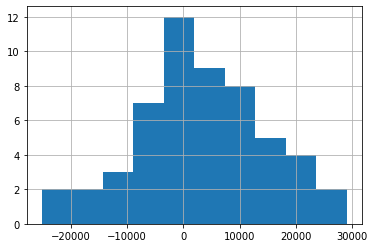

In [170]:
cleaned['ASPUS'].hist()

In [ ]:
#np.round(deseasoned_differenced.interpolate(method='time'),2)==0

In [ ]:
#plt.plot(cleaned.iloc[:,0])

In [ ]:
#cleaned_log.to_csv("cleaned.csv",index=True, index_label='Date')
cleaned.to_csv("cleaned.csv",index=True, index_label='Date')

In [ ]:
#cleaned = cleaned_log

In [ ]:
cleaned.dropna().apply(skew).hist()

In [ ]:
cleaned.dropna().apply(kurtosis).hist()

In [ ]:
cleaned.dropna().apply(adfuller).iloc[1,].hist()

In [ ]:
normal_list = []

for c in cleaned.columns:

    normal_list.append(testNormal(cleaned[[c]].loc[training].dropna()))
    

In [ ]:
newData = pd.DataFrame()
lambdas = []
for c in range(0,len(cleaned.columns)):
    if(normal_list[c]==1):

        newData = pd.concat([newData,cleaned[cleaned.columns[c]]],axis=1)
        lambdas.append(0)
    else:
        train_, l = transform_boxcox(cleaned[[cleaned.columns[c]]].loc[training].dropna())
        train_.index = cleaned[[cleaned.columns[c]]].loc[training].dropna().index
        test_ = transform_boxcox_l(cleaned[[cleaned.columns[c]]].loc[testing],l)   
        
        newData = pd.concat([newData,pd.concat([train_,test_])],axis=1)
        lambdas.append(l)

In [ ]:
#%matplotlib inline
#plt.plot(newData.dropna().iloc[:,102])
#plt.show()

In [ ]:
newData.to_csv("newData.csv",index=True, index_label='Date')

In [ ]:
#num = 10
#%matplotlib inline
#testNormal(cleaned.iloc[:,num]).dropna().plot.hist()
#plt.show()
#cleaned.iloc[:,num].dropna().plot.hist(alpha=0.5)

In [ ]:
#How many are stationary?
%matplotlib inline
pd.DataFrame(cleaned.dropna().apply(adfuller).iloc[1,]).iloc[:,0].hist()

In [ ]:
#for d in cleaned.columns:
    #print(d)

In [ ]:
#np.cumsum(x_names=='BOGZ1FL105015105Q')

In [ ]:
#len(cleaned.iloc[:,raw.columns=='BACDINA066MNFRBNY'])

In [ ]:
#for c in cleaned.columns:
    #print(y_name)


In [180]:
#ndif_results.loc['NROU']

0    1
Name: NROU, dtype: int64

In [179]:
#sndif_results.loc['NROU']

0    0
Name: NROU, dtype: int64

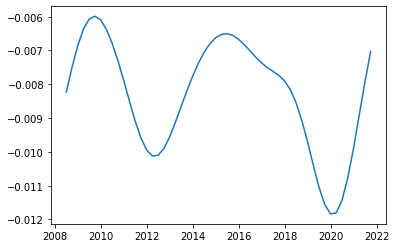

In [176]:
#plt.plot(raw_int['NROU'].diff())

In [ ]:
#client.restart()

In [ ]:
npa = []

for c in raw_int.columns:
    npa.append([c,cleaned.loc[training]])

In [ ]:
client = Client('192.168.3.100:8786')
#client.restart()
#small_set = random.sample(list(np.sort(cleaned.columns)),4)

#in order
future = client.map(returnCCFs, npa)

CCFs_ = client.gather(future)

client.close()
'''
best = -1
for f in as_completed(future):
    results.append(f.result())
'''
#for chosen in small_set:
#    run_analysis(chosen)

In [ ]:
#([name,data_final,ccf_scores, best_lags])
#[item[4] for item in CCFs_][0]

In [ ]:

#CCFs_data = pd.DataFrame([item[1] for item in CCFs_]).set_index([[item[0][0][0] for item in CCFs]])
CCF_names = [item[0] for item in CCFs_]
CCF_data = [item[1] for item in CCFs_]
CCF_scores = [item[2] for item in CCFs_]
CCF_best_lags = [item[3] for item in CCFs_]

#CCFs.columns = ['equal_var','equal_mean']
#.loc[raw_int.columns]

In [ ]:
#getDataMetrics(CCFs[0])

In [ ]:
#str(CCFs[113][0][0][2][0])=='nan'

#I don't want to derive metrics on training data

indexes_ = train_test_split(cleaned.loc[training].dropna().index, test_size=.5, random_state=0, shuffle=False)

npa = []

for n in cleaned.columns:
    name = n
    data = cleaned[n]
    train = indexes_[0]
    test = indexes_[1]
    npa.append([name,data,train,test])

metrics = clientFunction(getDataMetrics,npa)

'''
metrics = []

for a in range(0,len(CCFs)):
    if(str(CCFs[a][0][0][2][0])=='nan'):
        print(a)
        print(raw_int.columns[a])
        metrics.append('nan')
    else:
        metrics.append(getDataMetrics(np.array(CCFs)[a]))
'''

In [ ]:

data_metrics = pd.DataFrame([item[1] for item in metrics]).set_index([[item[0] for item in metrics]]).loc[raw_int.columns]
data_metrics.columns = ['equal_var','equal_mean','normal_tests']

In [ ]:
#pos = np.where(cleaned.columns==chosen)
#list(CCFs[pos[0][0]])

In [ ]:
#fit_sfs_models(CCFs[0][1])

In [ ]:
#temp = pd.concat([pd.DataFrame(cleaned['ASPUS']),pd.DataFrame(lagpad(cleaned['AWHAETP'],-1)).set_index(cleaned['AWHAETP'].index)],axis=1)
'''
len(training)
len(temp.index)

temp = pd.concat([pd.DataFrame(cleaned['ASPUS']),pd.DataFrame(lagpad(cleaned['AWHAETP'],0)).set_index(np.array(cleaned['AWHAETP'].index))],axis=1).dropna()
temp = temp[(temp.iloc[:,1].index>=training[0])*(temp.iloc[:,1].index<=training[-1])]
x = temp.iloc[:,1]
y = temp.iloc[:,0]
print(crosscorrelation(np.array(x),np.array(y), ccf_max_lag, mode='corr'))
print(temp.corr())
display(temp)
'''

#temp.loc[training].dropna().corr()

In [ ]:

npa = []

#queue size
for c in range(0, len(CCFs_)):
    npa.append([CCF_names[c],CCF_data[c]])


In [ ]:
#batch parallel
distance = 148

models_ = []
print(len(npa))
for r in range(0,(len(raw_int.columns)),distance):
    print(r,r+distance)
    
    #print(npa[r])
    #print((npa[r]+distance))
    
    batchset = npa[r:min(r+distance,len(CCFs_))]
    #CCFs_[npa[r]:min(npa[r]+distance,len(CCFs))]

    client = Client('192.168.3.100:8786')
    #clear ram before starting queue
    client.restart()

    future = clientFunction(fit_sfs_models, batchset)

    for m in future:
        models_.append(m)

client.close()
'''
#nonbatch

client = Client('192.168.3.100:8786')

#small_set = random.sample(list(np.sort(cleaned.columns)),4)

future = client.map(fit_sfs_models, CCFs, batch_size=64)

models_ = client.gather(future)

client.close()
'''


In [ ]:
#client.close()

In [ ]:
len([item[0] for item in models_])

In [ ]:

results_models_ = pd.DataFrame([item[1] for item in models_])#.set_index([item[0] for item in models_])

results_models_.index = [item[0] for item in models_]

models_results = results_models_.reindex(raw_int.columns)

In [ ]:
#problem children

In [ ]:
models_results.index

In [ ]:

#str(models_results.loc[models_results.index[113]].values)=='[nan]'
'''
start = 0
for m in models_results.index:
    start = start + 1
    print(start)
    #if(np.isnan(models_results.loc[m])):
    #if(models_results.loc[m]):
    print(models_results.loc[m])
'''

In [ ]:
'''
model_order = []
for m in models_results:
    if(m[1]=='error'):
        print('do nothing')
        #model_order.append('error')
    else:
        model_order.append(m[1])
     
#valid positions due to error (investigating showed large # of 0's in independent term).    
pos = []
for m in model_order:
    if (m=='error'):
        print('do nothing')
    else:
        pos.append(*np.where(np.array(cleaned.columns)==m)[0])
        
mask = np.ones(len(cleaned.columns), dtype=bool)
mask[pos] = False

failedresults = []
for m in cleaned.columns[mask]:
    failedresults.append(m)
                
'''

In [ ]:
#np.isnan(np.array(models_results)[113][0])

In [ ]:
#models with errors

problem_children = []

for m in range(0,len(models_results.index)):
    if(str(models_results.loc[models_results.index[m]].values)=='[nan]'):
        problem_children.append(models_results.index[m])
        
        #print problematic models
#plt.plot(raw_int.loc[:,['USREC'])

In [ ]:
print(problem_children)
#for p in problem_children:
#    print(np.where(models_results.index==p)[0][0])

In [ ]:
#recoveredModels = []

#check why
'''
for f in failedresults:
    CCF_pos = np.where(np.array(cleaned.columns)==f)[0][0]
    #CCFs[CCF_pos]
    recoveredModels.append(fit_sfs_models(CCFs[CCF_pos]))
'''

In [ ]:
#[c[0][0][0] for c in CCFs]

In [ ]:
#client.restart()

In [ ]:
npa = []
for c in range(0,len(CCF_names)):
    npa.append([CCF_names[c],CCF_data[c],CCF_scores[c],CCF_best_lags[c],models_results.loc[CCF_names[c]],training,testing])

In [ ]:
#npa[0][6]

In [ ]:
#restartClientFunction()


In [ ]:
#deriveWinners(npa[0])

In [ ]:
winners_ = clientFunction(deriveWinners,npa)

In [ ]:
winners_

results_winners_ = pd.DataFrame(np.array([item[1] for item in winners_]))#.set_index([item[0] for item in models_])

results_winners_.index = [item[0] for item in winners_]

winners_results = results_winners_.reindex(raw_int.columns)

winners_results.columns = ['winners']

In [ ]:
winners_results

In [ ]:
#winner_ = 
#pd.DataFrame([item[1] for item in winner_s]).set_index([[item[0] for item in winner_]]).loc[raw_int.columns]

In [ ]:
'''
winners_results = pd.DataFrame([results_winners_]).T
winners_results.index = results_winners_index
winners_results = winners_results.loc[raw_int.columns]
winners_results
'''

In [ ]:
#raw_int.columns

In [ ]:

def runModels(npa_):
    
    #[name,winners_,ccf_data,ccf_score,ccf_lags,ndif_results.iloc[c],sndif_results.iloc[c],training,testing]
    
    name = npa_[0]
    
    winners_ = npa_[1]
    data_final = npa_[2].dropna()
    ccf_scores = npa_[3]
    best_lags = npa_[4]
    nonseasonal = CCF_package = npa_[5]
    seasonal = CCF_package = npa_[6]
    train = npa_[7]
    train = npa_[8]
    
    if name in problem_children:
        return([name,['error','error'],'error','error','error','error'])
    
    #print(best_lags)
    #print(best_lags)

    cleaned_name_pos = np.where(np.array(cleaned.columns)==name)[0][0]
    
    model_pos = np.where(models_results.index==name)[0][0]
    #model_pos = np.where(np.array(models_results)==name)[0][0]
    
    #print(name)
    #data_final = npa_[1][1]
    
    if(str(npa_[1])=='error'):
            return([name,['error','error'],'error','error','error','error'])        

    #print(data_final).describe()
    #data_final = list(data_final)
    #.compute().loc[training],training,testing
    temp_train = data_final.loc[train].dropna()
    temp_test = data_final.loc[test].dropna()

    #drop zero variance columns
    drop = temp_train.columns[temp_train.apply(np.std)==0]
    #return(name)
    
    temp_train.drop(drop,axis=1,inplace=True)
    
    #fitted = models_results.loc[name][0]
    #models_[model_pos][1]

    #models = []
    
    #winners_ = model_winners[model_pos]

    #return(winners_)
    #return(len(temp_train[winners_]))
    
    #lagposition = []
    lagatposition = []
    lagatposition.append([name,0])
    #print(len(winners_))
    for s in range(0,len(winners_)):
        print(winners_[s])
        #lagposition.append(np.where(ccf_scores.columns==winners_[s])[0][0])
        #print(best_lags[np.where(ccf_scores.columns==winners_[s])[0][0]])
        print(best_lags[np.where(ccf_scores.columns==winners_[s])[0][0]])
        lagatposition.append([winners_[s],best_lags[np.where(ccf_scores.columns==winners_[s])[0][0]]])

    #return([lagposition,lagatposition])
    
    #print(temp_train)
    #print(winners_)
    #print(temp_train[winners_])
    X_train = sm.add_constant(temp_train[winners_])
    results_train = sm.OLS(temp_train['target'],X_train).fit()
    
    models = []
    models.append(results_train)
    #model = results

    summaries = []

    summaries.append(results_train.summary())
    
    X_train_test = sm.add_constant(data_final[winners_])
    results_train_test = sm.OLS(data_final['target'],X_train_test).fit()
    
    models.append(results_train_test)
    #model = results

    summaries.append(results_train_test.summary())
    
    #summary = results.summary()

    #value = np.where(raw_int.columns==name)[0][0]

    train_forecast = results_train.predict(temp_train[np.concatenate([['target'],winners_])])
    test_forecast = results_train.predict(temp_test[np.concatenate([['target'],winners_])])

    #MAPEs = []
    MAPE_in_sample = MAPE(temp_train['target'],train_forecast)
    MAPE_out_sample = MAPE(temp_test['target'],test_forecast)

    #index_ = []
    #seasonal first
    inverses = []

    inverses.append([name,sndif_results.loc[name][0],ndif_results.loc[name][0]])    

    for w in winners_:
        #value = np.where(raw_int.columns==w)[0][0]
        #index_.append(value)
        inverses.append([w,sndif_results.loc[w][0],ndif_results.loc[w][0]])
        #print(sndif_results.loc[w][0])
    #print("inverses")
    #print(inverses)        
    
    return([name,[MAPE_in_sample,MAPE_out_sample],models,summaries,lagatposition,inverses])

In [ ]:
npa = []
for c in range(0,len(CCF_names)):
    #ndif_results.iloc[c],sndif_results.iloc[c]
    name = CCF_names[c]
    ccf_data = CCF_data[c]
    ccf_score = CCF_scores[c]
    ccf_lags = CCF_best_lags[c]
    winners_ = winners_results.loc[raw_int.columns[c]][0]
    #model_ = 
    
    npa.append([name,winners_,ccf_data,ccf_score,ccf_lags,ndif_results.iloc[c],sndif_results.iloc[c],training,testing])
    


In [ ]:
restartClientFunction()    
ranModels = clientFunction(runModels,npa)
restartClientFunction()

In [ ]:
#sndif_results.loc['MSPUS']

In [ ]:
#[item[0] for item in ranModels]

In [ ]:
len(ranModels)

In [ ]:
#ranModels[2][4]

In [ ]:
#for r in range(0,len(ranModels)):
#    print(ranModels[r][0])
#    print(ranModels[r][5])
    
#[item[5] for item in ranModels]

In [ ]:
#pd.DataFrame(([item[5] for item in ranModels]))

In [157]:

ranModels_ = pd.concat([pd.DataFrame([item[1] for item in ranModels]),pd.DataFrame(np.array([item[2] for item in ranModels])),pd.DataFrame(np.array([item[3] for item in ranModels])),pd.DataFrame(np.array([item[4] for item in ranModels])),pd.DataFrame(np.array([item[5] for item in ranModels]))],axis=1)

ranModels_.index = [item[0] for item in ranModels]

ranModels_.columns = ['in-sample-mape','out-sample-mape', 'models', 'summaries','lags','seasonal_non']

ranModels_ = ranModels_.reindex(raw_int.columns)

In [ ]:
#np.where(ranModels_['out-sample-mape'].replace([np.inf, -np.inf], np.nan).dropna()=='error')
#plt.plot()

In [158]:
cleaned_ = ranModels_[['out-sample-mape']].replace([np.inf,'inf','error', -np.inf], np.nan).dropna().astype(float)

In [ ]:
#cleaned_

In [ ]:
'''
runningTotal = 0
values = []
for c in range(0,len(cleaned_)):
    values.append(float(cleaned_.iloc[c]))
    #print(runningTotal)
   
'''
#print(runningTotal/len(cleaned_))

In [ ]:
#pd.DataFrame(values).hist()

array([[<AxesSubplot:title={'center':'out-sample-mape'}>]], dtype=object)

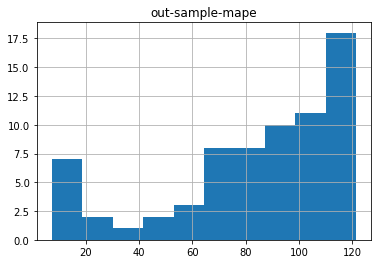

In [159]:
#plt.plot(cleaned_[cleaned_!="error"])
#plt.show()
#cleaned_ = cleaned_[cleaned_!="error"]
filters_out = ranModels_[['out-sample-mape']].replace([np.inf,'inf','error', -np.inf], np.nan).dropna().astype(float).quantile(q=[.02, .09, .25, .5, .75, .91, .98], interpolation='linear')
#cleaned_.quantile(q=[0, .25, .5, .75, 1], interpolation='linear')
filters_in = ranModels_[['in-sample-mape']].replace([np.inf,'inf','error', -np.inf], np.nan).dropna().astype(float).quantile(q=[.02, .09, .25, .5, .75, .91, .98], interpolation='linear')
#cleaned_[(cleaned_<=filters.iloc[3]) * (cleaned_>=filters.iloc[1])].hist()
#subset = cleaned_[(cleaned_<=filters.iloc[2])]
cleaned_[(cleaned_<=filters_out.iloc[2])].hist()


In [160]:
filters_out

,out-sample-mape
0.02,1.657996e+01
0.09,7.978978e+01
0.25,1.214774e+02
0.50,2.740981e+02
0.75,9.041755e+02
0.91,3.150224e+04
0.98,1.000228e+07


In [ ]:
#plt.plot(ranModels_results.dropna())
#plt.show()

In [ ]:
#for c in decent_models:
    #print(c)

In [ ]:
ranModels_.iloc[113][0]=='error'

In [161]:
r_sqr_in = []
for x in range(0,len(ranModels_['models'])):
    if(ranModels_.iloc[x][0]=='error'):
        r_sqr_in.append('error')
    else:
        #print(ranModels_['in_model'][x].rsquared)
        r_sqr_in.append(ranModels_['models'][x][0].rsquared)
        
r_sqr_full = []
for x in range(0,len(ranModels_['models'])):
    if(ranModels_.iloc[x][1]=='error'):
        r_sqr_full.append('error')
    else:
        #print(ranModels_['in_model'][x].rsquared)
        r_sqr_full.append(ranModels_['models'][x][1].rsquared)        

In [162]:
r_sqr_in_ = pd.DataFrame(r_sqr_in).replace('error',np.nan).set_index(raw_int.columns).dropna()
r_sqr_full_ =  pd.DataFrame(r_sqr_full).replace('error',np.nan).set_index(raw_int.columns).dropna()

filters = pd.concat([filters_in,filters_out,r_sqr_in_.quantile(q=[.02, .09, .25, .5, .75, .91, .98], interpolation='linear'),r_sqr_full_.quantile(q=[.02, .09, .25, .5, .75, .91, .98], interpolation='linear')],axis=1)
filters.columns = ['in-sample-mape','out-sample-mape','r_sqr_in','r_sqr_full']

In [163]:
together = pd.concat([ranModels_[['in-sample-mape']].replace([np.inf,'inf','error', -np.inf], np.nan).dropna().astype(float),ranModels_[['out-sample-mape']].replace([np.inf,'inf','error', -np.inf], np.nan).dropna().astype(float),r_sqr_in_,r_sqr_full_],axis=1).dropna()

In [164]:
together.columns = ['in-sample-mape','out-sample-mape','r_sqr_in','r_sqr_full']

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

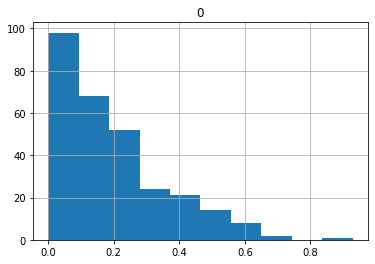

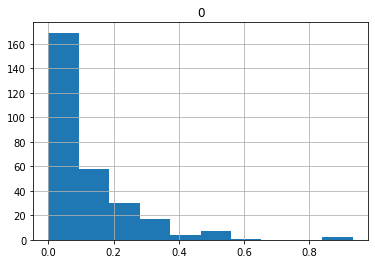

In [165]:
r_sqr_in_.hist()
r_sqr_full_.hist()

In [166]:
decent_models = together[((together['out-sample-mape'] <=filters['out-sample-mape'].iloc[3])*(together['r_sqr_in']>=filters['r_sqr_in'].iloc[5]))].index

In [ ]:
len(decent_models)

In [ ]:
len(models_results.loc[decent_models])

In [ ]:
#CCFs[np.where(raw_int.columns=='CSUSHPINSA')[0][0]][1].loc[training].dropna()['DFII10']

In [ ]:
'''
vars_ = list()
vars_.append('target')
for v in [*ranModels_.loc[decent_models].loc['CSUSHPINSA'][2].model.exog_names[1:]]:
    vars_.append(v)
''' 

In [ ]:
#CCFs_[np.where(raw_int.columns=='CSUSHPINSA')[0][0]]

In [ ]:
#CCFs[0][3]

In [ ]:

#CCFs[np.where(raw_int.columns=='CSUSHPINSA')[0][0]][1].loc[training].dropna()[vars_]

In [ ]:
#vars = [item[0] for item in ranModels_.loc[decent_models].iloc[m][5]][1:]

In [ ]:
#winners_results,ranModels_

In [ ]:
#np.where(CCF_names==decent_models[m])

In [ ]:
#ranModels_.loc[decent_models].iloc[m][2][1]

In [ ]:
#ranModels_.loc[decent_models].iloc[m][2][1].summary()

In [ ]:
#np.where(np.array(CCF_names)==CCF_names[1])

In [ ]:
#out_sample_training_prediction

In [ ]:
#CCF_data[np.where(np.array(CCF_names)==CCF_names[ccf_position])[0][0]].loc[training][vars_].dropna().iloc[:,1:]

In [ ]:
#ranModels_.loc[decent_models].loc[CCF_names[ccf_position]]['models'][0]

In [ ]:
#data_metrics.loc[decent_models[m]]

In [ ]:
    '''
    #return([name,[MAPE_in_sample,MAPE_out_sample],models,summaries,lagatposition,inverses])

    #seasonal = inverses[0][1][1]
    #nonseasonal = inverses[0][2][1]
    
    #print(season, seasonal, nonseasonal)

    #print(raw_int[name].index[np.argwhere(data_final.index==temp_train['target'].index[0])])
    
    train_prior_date = raw_int[name].index[np.argwhere(data_final.index==temp_train['target'].index[0]).ravel()[0]-nonseasonal-(seasonal*season)]
    train_prior_date_1 = raw_int[name].index[np.argwhere(data_final.index==temp_train['target'].index[0]).ravel()[0]-1]

    print(train_prior_date)
    #print(train_prior_date_1)
    train_xi=raw_int[name].loc[train_prior_date:train_prior_date_1]

    undiffed_train = pd.DataFrame(undiff(temp_train['target'], seasonal, nonseasonal, train_xi),columns=['target']).set_index(temp_train.index)
    undiffed_train_forecast = pd.DataFrame(undiff(train_forecast, seasonal, nonseasonal, train_xi),columns=['target']).set_index(temp_train.index)

    test_prior_date = raw_int[name].index[np.argwhere(data_final.index==temp_test['target'].index[0]).ravel()[0]-nonseasonal-(seasonal*season)]
    test_prior_date_1 = raw_int[name].index[np.argwhere(data_final.index==temp_test['target'].index[0]).ravel()[0]-1]

    test_xi = raw_int[name].loc[test_prior_date:test_prior_date_1]

    #[raw_int[name].loc[temp_train['target'].index[-1]]]
    undiffed_test_forecast = pd.DataFrame(undiff(test_forecast, seasonal, nonseasonal,test_xi),columns=['target']).set_index(temp_test.index)
    undiffed_test = pd.DataFrame(undiff(temp_test['target'].dropna(), 0, nonseasonal,test_xi),columns=['target']).set_index(temp_test.index)
    '''
    
    '''
    plt.plot(raw_int[name])
    plt.show()
    plt.plot(pd.concat([undiffed_train,undiffed_test],axis=0))
    plt.show()
    plt.plot(pd.concat([undiffed_train_forecast,undiffed_test_forecast],axis=0))
    plt.show()
    plt.plot(pd.concat([undiffed_train,undiffed_train_forecast],axis=1))
    plt.show()
    plt.plot(pd.concat([undiffed_test,undiffed_test_forecast],axis=1))
    plt.show()
    '''

    '''
    prior_date = raw_int[name].index[np.argwhere(raw_int.index==data_final['target'].dropna().index[0]).ravel()[0]-nonseasonal-(seasonal*season)]
    prior_date_1 = raw_int[name].index[np.argwhere(raw_int.index==data_final['target'].dropna().index[0]).ravel()[0]-1]

    xi=raw_int[name].loc[prior_date:prior_date_1]

    undiffed_ = pd.DataFrame(undiff(data_final['target'].dropna(), seasonal, nonseasonal, xi),columns=['target']).set_index(data_final['target'].dropna().index)

    prior_date_ = raw_int[name].index[np.argwhere(raw_int.index==results.fittedvalues.index[0]).ravel()[0]-nonseasonal-(seasonal*season)]
    prior_date_1_ = raw_int[name].index[np.argwhere(raw_int.index==results.fittedvalues.index[0]).ravel()[0]-1]

    xi_=raw_int[name].loc[prior_date_:prior_date_1_]

    undiffed_forecast = pd.DataFrame(undiff(results.fittedvalues, seasonal, nonseasonal, xi_),columns=['target']).set_index(results.fittedvalues.index)
    '''
    

In [ ]:
#m

In [ ]:
#undiff(out_sample_training_prediction, seasonal, nonseasonal,test_xi)

In [ ]:
#data_test.index

In [ ]:
#nonseasonal

In [ ]:
#seasonal

In [ ]:
#train_xi

In [ ]:
#nonseasonal

In [ ]:
#pd.DataFrame(undiff(data_train['target'], seasonal, nonseasonal, train_xi),columns=['target'])

In [ ]:
#pd.DataFrame(undiff(data_train['target'], seasonal, nonseasonal, train_xi),columns=['target']).set_index(data_train.index)

In [ ]:
#pd.DataFrame(undiff(data_train['target'], seasonal, nonseasonal, train_xi),columns=['target']).set_index(data_train.index)

In [ ]:
#ranModels_.loc[decent_models].iloc[m][5]

In [ ]:
#raw_int[name]

In [ ]:
#nonseasonal

In [ ]:
#raw_int[name].diff(1)

In [ ]:
#data_['target']

In [ ]:
#pd.DataFrame(undiff(data_['target'].dropna(), seasonal, nonseasonal,train_xi),columns=['target'])

ARIMA(order=(0, 0, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

NROU : target DFII10 M2V NROU USSTHPI
seasonal non: [['NROU', 0, 1], ['DFII10', 0, 1], ['M2V', 0, 1], ['NROU', 0, 1], ['USSTHPI', 0, 1]]
lags: [['NROU', 0], ['DFII10', 3], ['M2V', 1], ['NROU', 1], ['USSTHPI', 3]]
2009-06-30 00:00:00
2016-12-31 00:00:00
in_sample R2:  0.9287380165524085
out_sample R2:  0.930588198491608
in sample mape: 3.952671984740974
out sample mape: 7.193130629303892
                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     45.61
Date:                Sat, 15 Jan 2022   Prob (F-statistic):           7.00e-08
Time:                        19:06:57   Log-Likelihood:                 120.46
No. Observations:                  19   AIC:                            -230.9
Df Residuals:                      14   BIC:             

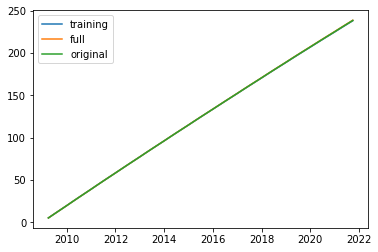

LQDT : target PSAVERT USPHCI DSEY
seasonal non: [['LQDT', 0, 1], ['PSAVERT', 0, 1], ['USPHCI', 0, 2], ['DSEY', 1, 1]]
lags: [['LQDT', 0], ['PSAVERT', 3], ['USPHCI', 4], ['DSEY', 3]]
2010-06-30 00:00:00
2016-12-31 00:00:00
in_sample R2:  0.5687802267823105
out_sample R2:  0.39934240743430927
in sample mape: 643.7152782745718
out sample mape: 78.18712365060958
                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.569
Model:                            OLS   Adj. R-squared:                  0.483
Method:                 Least Squares   F-statistic:                     6.595
Date:                Sat, 15 Jan 2022   Prob (F-statistic):            0.00464
Time:                        19:06:59   Log-Likelihood:                -29.222
No. Observations:                  19   AIC:                             66.44
Df Residuals:                      15   BIC:                             70.22
Df Mode

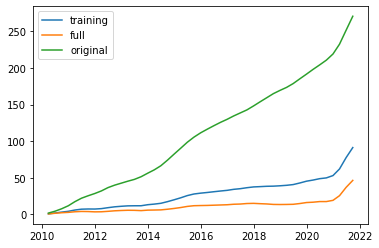

KWR : target CIVPART DTWEXBGS MPRIME PSAVERT TREAST WPU0911 NKE
seasonal non: [['KWR', 1, 1], ['CIVPART', 0, 1], ['DTWEXBGS', 0, 1], ['MPRIME', 0, 1], ['PSAVERT', 0, 1], ['TREAST', 0, 1], ['WPU0911', 0, 1], ['NKE', 0, 1]]
lags: [['KWR', 0], ['CIVPART', 2], ['DTWEXBGS', 1], ['MPRIME', 1], ['PSAVERT', 1], ['TREAST', 3], ['WPU0911', 4], ['NKE', 4]]
2009-09-30 00:00:00
2016-12-31 00:00:00
in_sample R2:  0.49337554640263537
out_sample R2:  0.2821551199302026
in sample mape: 111.91314213999762
out sample mape: 261.17083342883893
                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.171
Method:                 Least Squares   F-statistic:                     1.530
Date:                Sat, 15 Jan 2022   Prob (F-statistic):              0.253
Time:                        19:06:59   Log-Likelihood:                -40.4

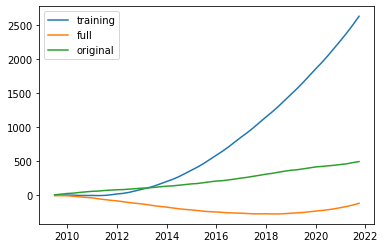

SITE : target M1V MICH POP JJU
seasonal non: [['SITE', 0, 1], ['M1V', 0, 1], ['MICH', 0, 1], ['POP', 1, 1], ['JJU', 0, 1]]
lags: [['SITE', 0], ['M1V', 1], ['MICH', 2], ['POP', 4], ['JJU', 3]]
2010-09-30 00:00:00
2016-12-31 00:00:00
in_sample R2:  0.5531081860239566
out_sample R2:  0.12294956991252515
in sample mape: 399.9106392237659
out sample mape: 192.9430699759996
                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.553
Model:                            OLS   Adj. R-squared:                  0.425
Method:                 Least Squares   F-statistic:                     4.332
Date:                Sat, 15 Jan 2022   Prob (F-statistic):             0.0173
Time:                        19:06:59   Log-Likelihood:                -51.561
No. Observations:                  19   AIC:                             113.1
Df Residuals:                      14   BIC:                             117

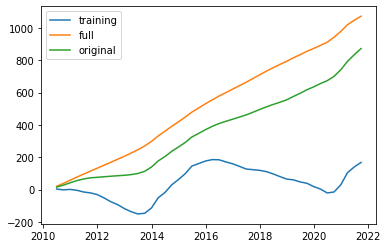

UNH : target CILACBQ158SBOG KCFSI MPRIME KO
seasonal non: [['UNH', 1, 1], ['CILACBQ158SBOG', 0, 1], ['KCFSI', 0, 1], ['MPRIME', 0, 1], ['KO', 0, 1]]
lags: [['UNH', 0], ['CILACBQ158SBOG', 3], ['KCFSI', 4], ['MPRIME', 2], ['KO', 3]]
2009-09-30 00:00:00
2016-12-31 00:00:00
in_sample R2:  0.46376653118885336
out_sample R2:  0.3631445246436319
in sample mape: 99.58172472355716
out sample mape: 217.5988062752803
                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.464
Model:                            OLS   Adj. R-squared:                  0.311
Method:                 Least Squares   F-statistic:                     3.027
Date:                Sat, 15 Jan 2022   Prob (F-statistic):             0.0541
Time:                        19:06:58   Log-Likelihood:                -42.672
No. Observations:                  19   AIC:                             95.34
Df Residuals:                      14

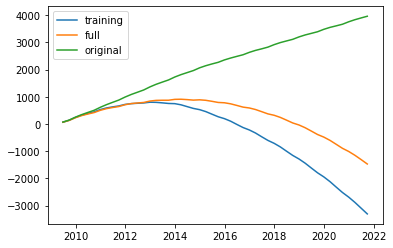

In [193]:

for m in range(0,len(ranModels_.loc[decent_models])):
    #if(ranModels_.loc[decent_models].iloc[m][2].rsquared>filters['r_sqr'].iloc[3]):
    if(ranModels_.loc[decent_models].iloc[m][2][0].rsquared>filters['r_sqr_in'].iloc[3]):
        ccf_position = np.where(np.array(CCF_names) == decent_models[m])[0][0]
        name = ranModels_.loc[decent_models].index[m]
        #print(data_metrics.loc[name])
        vars_ = ['target',*winners_results.loc[name][0]]
        #print(winners_results.loc[name][0])
        print(name, ':' ,*vars_)
        #CCF_data.loc[name]
        #dir(runModels(npa[0])[2][0])
        print("seasonal non:",ranModels_.loc[decent_models].iloc[m][5])
        print("lags:",ranModels_.loc[decent_models].iloc[m][4])
        print(CCF_data[ccf_position][vars_].dropna().index[1])
        print(training[-1])        
        print("in_sample R2: ", ranModels_.loc[decent_models].iloc[m][2][0].rsquared)
        print("out_sample R2: ", ranModels_.loc[decent_models].iloc[m][2][1].rsquared)
        print("in sample mape:",ranModels_.loc[decent_models].iloc[m][0])
        print("out sample mape:",ranModels_.loc[decent_models].iloc[m][1])        
        print(ranModels_.loc[decent_models].iloc[m][3][0])
        print(auto_arima(ranModels_.loc[decent_models].iloc[m][2][0].resid))
        print(ranModels_.loc[decent_models].iloc[m][3][1])
        print(auto_arima(ranModels_.loc[decent_models].iloc[m][2][1].resid))
        
        #print(CCF_data[ccf_position][vars_].dropna().describe())
        #in sample training prediction
        
        ranModels_.loc[decent_models].iloc[m][5]
        
        seasonal = ranModels_.loc[decent_models].iloc[m][5][0][1]
        
        nonseasonal = ranModels_.loc[decent_models].iloc[m][5][0][2]
        #print(nonseasonal)
        #print("difference:", "seasonal:", seasonal, "nonseasonal:",nonseasonal)
        
        data_ = CCF_data[np.where(np.array(CCF_names)==CCF_names[ccf_position])[0][0]]
        
        #print(data_[vars_].dropna())
        
        data_train = data_.loc[training][vars_].dropna()
        
        data_test = data_.loc[testing][vars_].dropna()
        
        train_prior_date = raw_int[name].index[np.argwhere(raw_int.index==data_train['target'].index[0]).ravel()[0]-nonseasonal-(seasonal*season)]
        train_prior_date_1 = raw_int[name].index[np.argwhere(raw_int.index==data_train['target'].index[0]).ravel()[0]-1]
        
        train_xi=raw_int[name].loc[train_prior_date:train_prior_date_1]
        
        undiffed_train = pd.DataFrame(undiff(data_train['target'], seasonal, nonseasonal, train_xi),columns=['target']).set_index(data_train.index)
    
        test_prior_date = raw_int[name].index[np.argwhere(raw_int.index==data_test['target'].index[0]).ravel()[0]-nonseasonal-(seasonal*season)]
        test_prior_date_1 = raw_int[name].index[np.argwhere(raw_int.index==data_test['target'].index[0]).ravel()[0]-1]

        test_xi = raw_int[name].loc[test_prior_date:test_prior_date_1]

        in_sample_training_prediction = ranModels_.loc[decent_models].loc[CCF_names[ccf_position]]['models'][0].predict(data_train)
        
        undiffed_in_sample_training_prediction = pd.DataFrame(undiff(in_sample_training_prediction, seasonal, nonseasonal, train_xi),columns=['target']).set_index(data_train.index)
        
        #out_sample training prediction
        out_sample_training_prediction = ranModels_.loc[decent_models].loc[CCF_names[ccf_position]]['models'][0].predict(data_test)

        undiffed_out_sample_training_prediction = pd.DataFrame(undiff(out_sample_training_prediction, seasonal, nonseasonal,test_xi),columns=['target'])
        
        #training model applied to all data
        training_prediction_all_data = ranModels_.loc[decent_models].loc[CCF_names[ccf_position]]['models'][0].predict(data_[vars_].dropna())

        undiffed_all_training_prediction = np.cumsum(pd.DataFrame(undiff(training_prediction_all_data, seasonal, nonseasonal,train_xi),columns=['target']).set_index(data_[vars_].dropna().index))
        
        #full model all data fit
        #inverse log
        #full_prediction_all_data = np.cumsum(unlog(ranModels_.loc[decent_models].loc[CCF_names[ccf_position]]['models'][1].predict(data_[vars_].dropna())))
        full_prediction_all_data = (ranModels_.loc[decent_models].loc[CCF_names[ccf_position]]['models'][1].predict(data_[vars_].dropna()))
        
        #undiffed_all_full_prediction = np.cumsum(unlog(pd.DataFrame(undiff(full_prediction_all_data, seasonal, nonseasonal,train_xi),columns=['target']).set_index(data_[vars_].dropna().index)))
        undiffed_all_full_prediction = np.cumsum((pd.DataFrame(undiff(full_prediction_all_data, seasonal, nonseasonal,train_xi),columns=['target']).set_index(data_[vars_].dropna().index)))

        #original_data = np.cumsum(unlog(pd.DataFrame(undiff(data_[vars_].dropna()['target'], seasonal, nonseasonal,train_xi),columns=['target']).set_index(data_[vars_].dropna().index)))
        original_data = np.cumsum((pd.DataFrame(undiff(data_[vars_].dropna()['target'], seasonal, nonseasonal,train_xi),columns=['target']).set_index(data_[vars_].dropna().index)))
        
        #original_data = cleaned.loc[full_prediction_all_data.index][decent_models[m]]
        
        #combined = pd.concat([pd.DataFrame(training_prediction_all_data), pd.DataFrame(full_prediction_all_data), pd.DataFrame(original_data)],axis=1)
        
        combined = pd.concat([pd.DataFrame(undiffed_all_training_prediction), pd.DataFrame(undiffed_all_full_prediction), pd.DataFrame(original_data)],axis=1)
        
        combined.columns = ["training","full","original"]
        #plt.plot(original_data)
        #plt.plot(training_prediction_all_data)
        #plt.plot(full_prediction_all_data)
        plt.plot(combined)
        plt.legend(["training","full","original"],loc='upper left')
        
        plt.show()


In [ ]:
#dir(ranModels_.loc[decent_models].iloc[m][3])

In [ ]:
#now sorted by model return pos
'''
batchSet = np.array(CCFs)[pos]
client = Client('192.168.3.100:8786')

client.restart()

future = client.map(runModels, batchSet,batch_size=64)

models_ran = client.gather(future)
client.restart()
client.close()
'''

In [ ]:
'''
X_train = temp_train[winners_]

y_train = temp_train['target']

kfold = KFold(n_splits=numCV, shuffle=True)

#used for pcorr kfolds as well as best subsets
train_ = []
test_ = []

kfold.get_n_splits(X_train.index)

for train_indices, test_indices in kfold.split(X_train.index):
    train_.append(train_indices)
    test_.append(test_indices)

threshold = .05

set_ = list(winners_)

max_pvalue = 1

subset = temp_train[np.concatenate([['target'],winners_])]

n=len(subset)

while(max_pvalue>=threshold):

    dist = scipy.stats.beta(n/2 - 1, n/2 - 1, loc=-1, scale=2)
    p_values = pd.DataFrame(2*dist.cdf(-abs(subset.pcorr()['target']))).T
    p_values.columns = list(subset.columns)

    max_pname = p_values.idxmax(axis=1)[0]
    max_pvalue = p_values[max_pname].values[0]

    #print(max_pvalue, max_pname)

    #to prevent errors, always return 1 value
    if len(set_)==1:
        break

    if (max_pvalue > threshold):

        set_.remove(max_pname)
        temp = [target]
        temp.extend(set_)
        subset = subset[temp]

        max_pname=""
'''

In [ ]:
'''
small_set = random.sample(list(np.sort(cleaned.columns)),1)

runs = []
for chosen in small_set:
    runs.append(run_analysis(chosen))
'''

In [ ]:
'''
print('chosen', chosen, 'training vs holdout f test for equal variance', training_vs_holdout_f_test[1])
'''
#CV Plot
fig = plot_sfs(fitted.get_metric_dict(), kind='std_err')
plt.title('Sequential Forward Selection (w. StdErr)')
plt.savefig(str(target)+'.png', dpi=300, format='png', bbox_inches='tight')

metric_table = pd.DataFrame(fitted.get_metric_dict()).T
#print(metric_table)
plt.plot(metric_table['avg_score'])
plt.savefig(str(target)+'metric.png', dpi=300, format='png', bbox_inches='tight')


for w in range(0,len(winners_)):
    print(winners_[w])
    value = np.where(raw_int.columns==winners_[w])[0][0]
    print(inverses[w])
    print('lags:', best_lags[np.where(ccf_scores.columns==winners_[w])[0][0]])
    print('sndif:', sndif[value])
    print('ndif:', ndif[value])



print(seasonal)
print(nonseasonal)

print(chosen,'Population', 'Equal mean:', equal_mean, ', ', 'Population', 'Equal variance:', equal_var)

print(chosen)

value = np.where(raw_int.columns==chosen)[0][0]

#print(
print('sndif:', sndif[value])
print('ndif:', ndif[value])

for w in set_:
    plt.scatter(temp_train[['target']], temp_train[[w]])
    plt.show()        

#%matplotlib inline
corrMatrix = pd.concat([temp_train['target'],temp_train[winners_]],axis=1).corr().sort_values(kind="quicksort", by='target', ascending=False,key=abs)
sn.heatmap(corrMatrix, annot=True)

pcorrMatrix = pd.concat([temp_train['target'],temp_train[winners_]],axis=1).pcorr().sort_values(kind="quicksort", by='target', ascending=False,key=abs)
sn.heatmap(pcorrMatrix, annot=True)

#for w in winners_:
sn.set_theme(style="ticks")

t = temp_train[np.concatenate([['target'],winners_])]
t_ = t[['target']]
t_.columns = ['target2']
#t_.rename('target2')
t = pd.concat([t,t_],axis=1)
sn.pairplot(t, hue="target")
#plt.scatter(temp_train[['target']], temp_train[[w]])


print(chosen)

for s in range(0,len(set_)):
    print(np.where(ccf_scores.columns==set_[s])[0][0])

print(MAPE(temp_test['target'],test_forecast))

index_ = []

for w in set_:
    print(w)
    value = np.where(raw_int.columns==w)[0][0]
    index_.append(value)
    inverses.append([w,sndif[value],ndif[value]])
    print('lags:', best_lags[np.where(ccf_scores.columns==set_[s])[0][0]])
    print('sndif:', sndif[value])
    print('ndif:', ndif[value])

#%matplotlib inline
corrMatrix = pd.concat([temp_train['target'],temp_train[set_]],axis=1).corr().sort_values(kind="quicksort", by='target', ascending=False,key=abs)
sn.heatmap(corrMatrix, annot=True)

pcorrMatrix = pd.concat([temp_train['target'],temp_train[set_]],axis=1).pcorr().sort_values(kind="quicksort", by='target', ascending=False,key=abs)
sn.heatmap(pcorrMatrix, annot=True)


In [ ]:
#len(ccf_scores.columns)

In [ ]:
#data_final_dask = dd.from_pandas(data_final,npartitions=128)
#data_final_dask_w_y = dd.concat([cleaned[[y_name]],data_final_dask.compute()],axis=1)
#names_ = ['target']
#names_.extend(cleaned.columns)
#data_final_dask_w_y.columns = names_

In [ ]:
#data_final_dask.apply(np.cumsum,axis=1).compute()


In [ ]:
#len(data_final.columns)

In [ ]:
#plt.plot(raw_int[chosen])
#plt.plot(cleaned[chosen])
#plt.plot(data_final_dask_w_y[chosen].compute())
#plt.plot(data_final_dask_w_y[['target']].compute().loc[training])

In [ ]:
#np.sort(data_final_dask_w_y.compute().isna().sum())

In [ ]:
'''
zca1_subset = working_set[subset.columns.difference(['target',max_pname])].dropna()
zca1 = zca.fit(zca1_subset)
zca1_df = pd.DataFrame(zca1.transform(zca1_subset))
zca1_df.columns = zca1_subset.columns
zca1_df.index = zca1_subset.index

zca1_subset = working_set[subset.columns.difference(['target',max_pname])].dropna()
zca1 = zca.fit(zca1_subset)
zca1_df = pd.DataFrame(zca1.transform(zca1_subset))
zca1_df.columns = zca1_subset.columns
zca1_df.index = zca1_subset.index
#pd.concat([target,zca1],axis=1)
'''

In [ ]:
'''
newindex = []

for i in range(0,len(temp_train.index)):
    newindex.append(temp_train.index[i])

for i in range(0,nonseasonal):
    newindex.append(last_day_of_month(temp_train.index[-1] + pd.DateOffset(90*i)))
    
len(newindex)


'''

In [ ]:
'''

future = client.map(regress, X)

results = []
best = -1
for f in as_completed(future):
    results.append(f.result())
    
def y_subset(df):
    
    X = list ()
    
    for var_pos in range(0,len(df.columns)):
        variables=df.columns
        target=variables[var_pos]
        #print(target)
        #print(variables.isin([target]))
        temp = pd.concat([pd.DataFrame(df[target]),df_.loc[:, ~df.columns.isin([target])]],axis=1)
        #print(temp)
        X.append(temp)
    return(X)
    '''

In [ ]:
'''
scaler = StandardScaler()

tscv = TimeSeriesSplit(n_splits = 5)

#scaler.fit(np.array(data_final_dask_w_y[['target']].compute().loc[training]).reshape(-1, 1))

New_Names = list(data_final_dask_w_y.columns.difference(['target']))

outer_dataset = data_final_dask_w_y.compute().loc[training].dropna()
target = outer_dataset[['target']]

subset = pd.concat([target,outer_dataset[New_Names]],axis=1)

num_folds = 2
#kfold = KFold(n_splits=num_folds, shuffle=False)
#train, test = kfold.get_n_splits(outer_dataset.index)

p_threshold = .05

iteration = 0
max_pvalue = 1

while(max_pvalue>=.05):
#
    print(chosen)
    
    print(New_Names)
    
    n_p_values = pd.DataFrame()

    p_values = []
    
    #parallelize here (x16)
    for n in New_Names:
        #print(n)
        New_Names_testing = list(np.array(New_Names)[(np.array(New_Names)!=n)])
        p_values.append(pvalues(n))
        
    p_values_df = pd.DataFrame(p_values,index=New_Names)
    print(p_values_df)

    max_pname = New_Names[np.argmax(p_values_df)]
    max_pvalue = p_values[np.argmax(p_values_df)]

    #n_p_values = pd.concat([n_p_values,p_values],axis=0)
    #print(n_p_values)

    if (max_pvalue > .05):
        print([max_pname, max_pvalue])
        #New_Names.remove(max_pname)
        #New_Names_testing = list(np.array(New_Names_testing)[(np.array(New_Names_testing)!=max_pname)])
        New_Names = list(np.array(New_Names)[(np.array(New_Names)!=max_pname)])
        temp = ['target']
        temp.extend(New_Names)
        subset = subset[temp]
    print()
'''

In [ ]:
#restartClientFunction()

In [ ]:
#data_temp = data_final_dask_w_y.compute()

In [ ]:
#subset[New_Names]

In [ ]:
'''
includes = []
for c in subset.columns:
    index = np.argwhere(data_final_dask_w_y.columns==c)[0][0]
    includes.append(index)
'''

In [ ]:
#reg = train(data_final_dask_w_y[subset.columns].compute().loc[training].dropna())
#subset.dropna()


In [ ]:
#reg = regress(data_final_dask_w_y[subset.columns].compute().dropna())

#### 